<a href="https://colab.research.google.com/github/Mohamedragih1/Arabic-Optical-Character-Recognition-OCR-/blob/main/data_processing_augmentation__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Processing and augmentation


## Importing the necessary libraries

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.model_selection import train_test_split
import kagglehub
import numpy as np
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import zscore

## Preprocessing the images

Preprocesses an image by resizing, converting it to grayscale, binarizing it (inverting black and white regions), and saving the processed image to a specified output folder.

In [ ]:
def preprocess_image(image_path, output_folder):
    img = cv2.imread(image_path)

    resized_img = cv2.resize(img, (800, 600))

    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    _, binary_img = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

    output_path = os.path.join(output_folder, os.path.basename(image_path))
    cv2.imwrite(output_path, binary_img)

In [ ]:
# Download latest version
path =kagglehub.dataset_download("iraqyomar/khatt-arabic-hand-written-lines")
input_folder = os.path.join(path, "images")
#input_folder = '/kaggle/input/khatt-arabic-hand-written-lines/images'
output_folder = '/kaggle/working/output_images'


if not os.path.exists(output_folder):
    os.makedirs(output_folder)
#preprocess each image
for filename in os.listdir(input_folder):
    if filename.endswith('.tif') or filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(input_folder, filename)
        preprocess_image(image_path, output_folder)

resizing images, pairing them with their associated text labels, and storing the data in a pandas DataFrame for easier handling.

In [ ]:
images_folder = '/kaggle/working/output_images'
#labels_folder = '/kaggle/input/khatt-arabic-hand-written-lines/labels'
labels_folder = os.path.join(path, "labels")
target_size = (800, 100)

data = []

for image_file in os.listdir(images_folder):
    if image_file.endswith(('.png', '.jpg', '.jpeg')):

        image_path = os.path.join(images_folder, image_file)
        image = Image.open(image_path)
        image_resized = image.resize(target_size)
        image_array = np.array(image_resized)

        # Get corresponding label
        label_file = os.path.splitext(image_file)[0] + '.txt'
        label_path = os.path.join(labels_folder, label_file)
        if os.path.exists(label_path):
            with open(label_path, 'r', encoding='windows-1256') as f:
                label = f.read().strip()
        else:
            label = None

        # Add image array and label to data list
        data.append({'image': image_array, 'label': label})

# Create DataFrame from the data list
df = pd.DataFrame(data)
df.head()

,image,label
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",المعاصرة . أما قدماء أهل العراق، فقد عرف عندهم...
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",ص غ هـ أ ننا في الحج . هل تعلم فائدة الكلمات ا...
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",بدات قوافل الحجيع حاج إثر آخر يلبي . عندوصولنا...
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",لزمتك. سألت راجح هل بلغ أححابنا ظ ع ك ، ث خ ض،...
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",المجال هناك رأي مختلف حول مدلول السلالة الجغرا...


في صدر الإسلام  غابات تثير فيها  الأسود ، وهو ما يتعارض مع


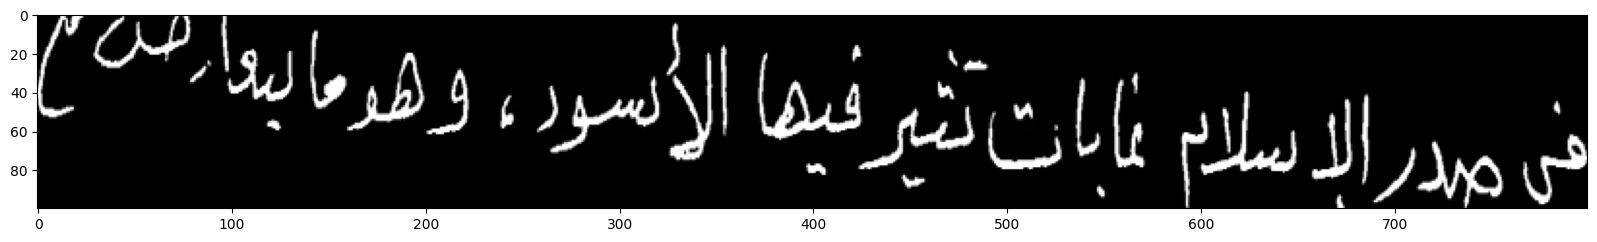

بدأت قوافل الحجيج حاج إثر آخر يلبي . عند وصولنا طفنا وسعينا مع شيخ. كان جاري


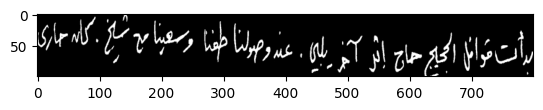

كانوا قد سمعوا يما ود د عن حادث "نجران" من أخبار. وقد ذكر أن


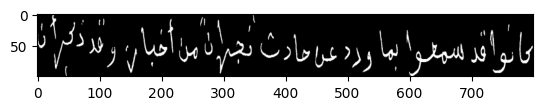

سألت راجح هل بلغ أصحابنا ظ ع ك ، ث خ ض ، ب س ش ، ص غ هـ  أننا في الحج . هل


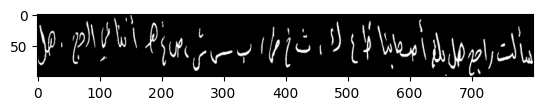

وينتظر الفلاح سبعين يوما" ليحصد الشعير والعدس وحكر سنة ، أما القمـح


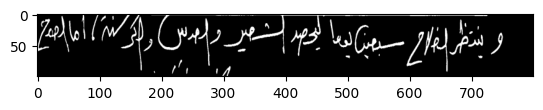

In [ ]:
#Displaying sample of images with its labels

# Select random indices
random_indices = random.sample(range(len(df)), 5)  # Selecting 5 random images

# Plot images and labels
fig = plt.figure(figsize=(20, 4))
for i, idx in enumerate(random_indices, 1):
    image_array = df.loc[idx, 'image']
    label = df.loc[idx, 'label']
    plt.imshow(image_array,cmap = 'gray')
    print(label)
    plt.show()

## Data augmentation

This script performs image augmentation to enhance the diversity of training data. It includes the following functionalities:

1. **Geometric Distortion**: Applies random scaling and slight rotations to the image to simulate variations in size and orientation. This helps the model generalize to different perspectives and layouts.

2. **Perspective Transformation**: Alters the perspective of the image by shifting its corner points randomly. This simulates changes in viewing angles or camera positions, improving robustness to skewed inputs.

3. **Augmentations Workflow**:
   - Iterates over all input images and labels.
   - Applies each augmentation technique to generate new images while preserving the original labels.
   - Optionally visualizes the augmentations for inspection.

4. **Augmented Dataset Output**:
   - Returns an augmented dataset containing the original and modified images with their corresponding labels.
   - Prints the shapes of the augmented data for validation.



In [ ]:
def geometric_distortion(image):
    """
    Apply geometric distortions to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Geometrically distorted image
    """
    rows, cols = image.shape

    scale_x = random.uniform(0.6, 1.4)
    scale_y = random.uniform(0.6, 1.4)

    angle = random.uniform(-3, 3)

    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    distorted = cv2.warpAffine(image, M, (cols, rows))

    return cv2.resize(distorted, (cols, rows))


def perspective_transformation(image):
    """
    Apply perspective transformation to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Perspective-transformed image
    """
    rows, cols = image.shape

    src_points = np.float32([
        [0, 0],
        [cols-1, 0],
        [0, rows-1],
        [cols-1, rows-1]
    ])

    offset = 30
    dest_points = np.float32([
        [random.uniform(0, offset), random.uniform(0, offset)],
        [random.uniform(cols-1-offset, cols-1), random.uniform(0, offset)],
        [random.uniform(0, offset), random.uniform(rows-1-offset, rows-1)],
        [random.uniform(cols-1-offset, cols-1), random.uniform(rows-1-offset, rows-1)]
    ])

    M = cv2.getPerspectiveTransform(src_points, dest_points)
    transformed = cv2.warpPerspective(image, M, (cols, rows))

    return transformed

def augment_images(X, y, visualize=False):
    """
    Augment images with multiple techniques.

    Args:
        X (np.ndarray): Input images
        y (np.ndarray): Corresponding labels
        visualize (bool): Whether to visualize augmentations

    Returns:
        Tuple of augmented images and labels
    """
    X_augmented = []
    y_augmented = []

    viz_count = 0

    for image, label in zip(X, y):
        X_augmented.append(image)
        y_augmented.append(label)

        augmentation_techniques = [
            geometric_distortion,
            perspective_transformation
        ]

        for augment_func in augmentation_techniques:

            augmented_image = augment_func(image)

            if visualize and viz_count < 4:
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.title('Original')
                plt.imshow(image, cmap='gray')
                plt.subplot(132)
                plt.title(augment_func.__name__)
                plt.imshow(augmented_image, cmap='gray')
                plt.show()
                viz_count += 1

            # Add augmented image
            X_augmented.append(augmented_image)
            y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

def main(X, y, visualize=False):
    """
    Main augmentation workflow.

    Args:
        X (np.ndarray): Input images
        y (np.ndarray): Corresponding labels
        test_size (float): Proportion of test set
        random_state (int): Random seed for reproducibility
        visualize (bool): Whether to visualize augmentations

    Returns:
        Augmented training and test sets
    """

    X_train_augmented, y_train_augmented = augment_images(
        X, y, visualize=visualize
    )

    print("\nAugmented Dataset:")
    print(f"X_train_augmented shape: {X_train_augmented.shape}")
    print(f"y_train_augmented shape: {y_train_augmented.shape}")

    return X_train_augmented, y_train_augmented

 # Permutations

In [ ]:
import numpy as np
import cv2
import random
from itertools import permutations
import matplotlib.pyplot as plt

def geometric_distortion(image):
    """
    Apply geometric distortions to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Geometrically distorted image
    """
    rows, cols = image.shape

    scale_x = random.uniform(0.6, 1.4)
    scale_y = random.uniform(0.6, 1.4)

    angle = random.uniform(-3, 3)

    M = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)

    distorted = cv2.warpAffine(image, M, (cols, rows))

    return cv2.resize(distorted, (cols, rows))

def perspective_transformation(image):
    """
    Apply perspective transformation to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Perspective-transformed image
    """
    rows, cols = image.shape

    src_points = np.float32([
        [0, 0],
        [cols-1, 0],
        [0, rows-1],
        [cols-1, rows-1]
    ])

    offset = 30
    dest_points = np.float32([
        [random.uniform(0, offset), random.uniform(0, offset)],
        [random.uniform(cols-1-offset, cols-1), random.uniform(0, offset)],
        [random.uniform(0, offset), random.uniform(rows-1-offset, rows-1)],
        [random.uniform(cols-1-offset, cols-1), random.uniform(rows-1-offset, rows-1)]
    ])

    M = cv2.getPerspectiveTransform(src_points, dest_points)
    transformed = cv2.warpPerspective(image, M, (cols, rows))

    return transformed

def elastic_deformation(image):
    """
    Apply elastic deformation to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Elastically deformed image
    """
    rows, cols = image.shape
    
    # Create displacement fields
    dx = np.random.rand(rows, cols) * 2 - 1
    dy = np.random.rand(rows, cols) * 2 - 1
    
    # Gaussian filter the displacement fields
    sigma = random.uniform(30, 60)
    dx = cv2.GaussianBlur(dx, (0, 0), sigma)
    dy = cv2.GaussianBlur(dy, (0, 0), sigma)
    
    # Normalize displacement fields
    dx = dx * random.uniform(5, 15)
    dy = dy * random.uniform(5, 15)
    
    # Create mesh grid
    x, y = np.meshgrid(np.arange(cols), np.arange(rows))
    
    # Add displacement fields to the mesh grid
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)
    
    # Apply the transformation
    return cv2.remap(image, map_x, map_y, cv2.INTER_LINEAR)

def shear_transformation(image):
    """
    Apply shear transformation to the image.

    Args:
        image (np.ndarray): Input image

    Returns:
        np.ndarray: Sheared image
    """
    rows, cols = image.shape
    
    # Random shear factors
    shear_factor_x = random.uniform(-0.3, 0.3)
    shear_factor_y = random.uniform(-0.3, 0.3)
    
    # Create shear matrix
    M = np.float32([
        [1, shear_factor_x, 0],
        [shear_factor_y, 1, 0]
    ])
    
    # Apply transformation
    sheared = cv2.warpAffine(image, M, (cols, rows))
    
    return sheared

def augment_images(X, y, visualize=False, num_augmentations=2):
    """
    Augment images with random permutations of multiple techniques.

    Args:
        X (np.ndarray): Input images
        y (np.ndarray): Corresponding labels
        visualize (bool): Whether to visualize augmentations
        num_augmentations (int): Number of augmentation combinations to apply per image

    Returns:
        Tuple of augmented images and labels
    """
    X_augmented = []
    y_augmented = []

    viz_count = 0

    augmentation_techniques = [
        geometric_distortion,
        perspective_transformation,
        elastic_deformation,
        shear_transformation
    ]

    # Get all possible permutations of augmentation functions
    all_permutations = list(permutations(augmentation_techniques, 2))

    for image, label in zip(X, y):
        # Add original image
        X_augmented.append(image)
        y_augmented.append(label)

        # Randomly select num_augmentations permutations
        selected_permutations = random.sample(all_permutations, min(num_augmentations, len(all_permutations)))

        for augment_sequence in selected_permutations:
            # Apply sequence of augmentations
            augmented_image = image.copy()
            for augment_func in augment_sequence:
                augmented_image = augment_func(augmented_image)

            if visualize and viz_count < 4:
                plt.figure(figsize=(15, 5))
                plt.subplot(131)
                plt.title('Original')
                plt.imshow(image, cmap='gray')
                plt.subplot(132)
                plt.title(' → '.join([f.__name__ for f in augment_sequence]))
                plt.imshow(augmented_image, cmap='gray')
                plt.show()
                viz_count += 1

            # Add augmented image
            X_augmented.append(augmented_image)
            y_augmented.append(label)

    return np.array(X_augmented), np.array(y_augmented)

### Splitting the data to train and test

In [ ]:
# Convert image arrays to numpy arrays
X = np.array(df['image'].tolist())
y = df['label'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the split datasets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (9100, 100, 800)
X_test shape: (2275, 100, 800)
y_train shape: (9100,)
y_test shape: (2275,)


بث ، نسر .


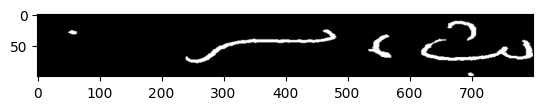

In [ ]:
print(y_train[1000])
plt.imshow(X_train[1000],cmap = 'gray')

### Applying augmentation on the training data

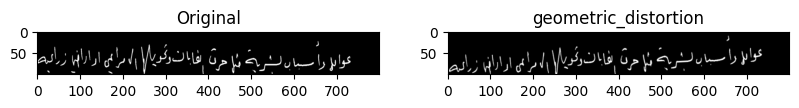

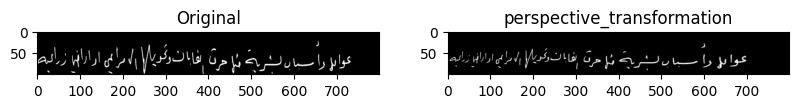

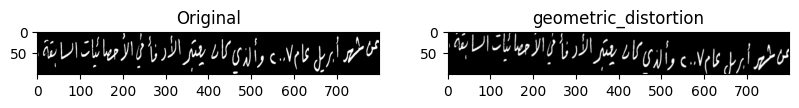

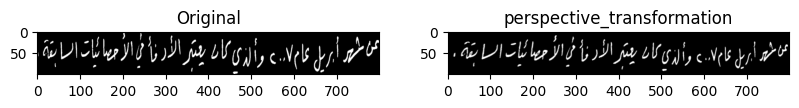


Augmented Dataset:
X_train_augmented shape: (27300, 100, 800)
y_train_augmented shape: (27300,)
(27300, 1, 100, 800)


In [ ]:
#applying augmentation to the train data
X_train_aug, y_train_aug= main(X_train, y_train,visualize=True)
X_train_aug = np.expand_dims(X_train_aug, axis=1)
print(X_train_aug.shape)

## Loading, building and using the model.

In [ ]:
#Importing required dependencies
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import transformers
from transformers import AutoModel, AutoTokenizer, AutoFeatureExtractor, Swinv2ForImageClassification
from torchvision import transforms


In [ ]:
class Image_text_dataset(Dataset):

  def __init__(self, images, labels, tokenizer, feature_extractor):
    super().__init__()
    self.images = images # Images are stored in a np.ndarray with dimensions (27300, 100, 800)
    self.labels = labels # corresponding ground truth labels with dimensions (27300,)
    self.tokenizer = tokenizer # pre-trained model(Arbert) tokenizer.
    self.feature_extractor = feature_extractor # pre-trained vision transformer model (preprocessing)

    #Calculating maximum text length
    max_text_length = 0
    for label in self.labels:
      max_text_length = max(max_text_length, len(label.split()))
    self.max_text_length = max_text_length # max text length used for padding text sequences

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    image = self.images[index]
    label = self.labels[index]

    processed_image = self.feature_extractor(image, return_tensors="pt").pixel_values.squeeze(0)

    encoded_label = self.tokenizer(label, max_length = self.max_text_length, padding= "max_length", truncation=True, return_tensors="pt")
    encoded_label = encoded_label["input_ids"].squeeze(0)
    attention_mask = encoded_label["attention_mask"].squeeze(0)

    return {"processed_image": processed_image,
            "encoded_label": encoded_label,
            "attention_mask": attention_mask}

In [ ]:
class OCR_model(nn.Module):

  def __init__(self, encoder_model_name, decoder_model_name):
    super().__init__()
    self.encoder = AutoModel.from_pretrained(encoder_model_name)
    self.decoder = Swinv2ForImageClassification.from_pretrained(decoder_model_name)
    self.linear_projection = nn.Linear(self.encoder.config.hidden_size, self.decoder.config.hidden_size)
    self.linear = nn.Linear(self.decoder.config.hidden_size, self.decoder.config.vocab_size)

  def forward(self, images, input_ids, attention_mask):
    Image_features = self.encoder(pixel_values= images).last_hidden_state
    projected_features = self.linear_projection(Image_features)
    Text_features = self.decoder(input_ids = input_ids, attention_mask = attention_mask, encoder_hidden_state = projected_features).last_hidden_state
    logits = self.linear(Text_features)
    return logits

In [ ]:
#Implementing the training loop

encoder_model_name = "microsoft/swinv2-tiny-patch4-window16-256"
decoder_model_name = "UBC-NLP/ARBERTv2"
feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_model_name)
tokenizer = AutoTokenizer.from_pretrained(decoder_model_name)
dataset = Image_text_dataset(X_train_aug, y_train_aug, tokenizer, feature_extractor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
print(dataloader)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = OCR_model(encoder_model_name, decoder_model_name).to(device)

You are using a model of type bert to instantiate a model of type swinv2. This is not supported for all configurations of models and can yield errors.
Some weights of Swinv2ForImageClassification were not initialized from the model checkpoint at UBC-NLP/ARBERTv2 and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.norm.bias', 'embeddings.norm.weight', 'embeddings.patch_embeddings.projection.bias', 'embeddings.patch_embeddings.projection.weight', 'encoder.layers.0.blocks.0.attention.output.dense.bias', 'encoder.layers.0.blocks.0.attention.output.dense.weight', 'encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.0.bias', 'encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.0.weight', 'encoder.layers.0.blocks.0.attention.self.continuous_position_bias_mlp.2.weight', 'encoder.layers.0.blocks.0.attention.self.key.weight', 'encoder.layers.0.blocks.0.attention.self.logit_scale', 'encoder.layers.0.blocks.0.attention.self.query.bias

In [ ]:

# Load the feature extractor
feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_model_name)

# Define the grayscale normalization parameters
# These values are based on common practice for grayscale images. You can adjust them if necessary.
mean = [0.5]  # Grayscale images typically have mean values around 0.5
std = [0.5]   # Standard deviation can be adjusted accordingly

# Create a custom normalization transform
normalize_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3 channels (RGB)
    transforms.Normalize(mean=mean, std=std)      # Normalize with grayscale mean/std
])

# You can now pass this normalization transform into the feature extractor.
feature_extractor = AutoFeatureExtractor.from_pretrained(encoder_model_name)
feature_extractor.transforms = normalize_transform

# Now you can use the feature_extractor as before with grey_scale images

In [ ]:
# Assuming dataloader is instantiated with Image_text_dataset
for epoch in range(5):
    total_loss = 0
    for batch in dataloader:
        # Extract data from batch
        images = batch['processed_image'].to(device)
        input_ids = batch['encoded_label'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        # Forward pass
        outputs = model(images, input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Compute loss
        loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)
        loss = loss_fn(logits.view(-1, logits.size(-1)), input_ids.view(-1))

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader)}")


ValueError: mean must have 1 elements if it is an iterable, got 3